In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Add, Multiply, GRU, GlobalAveragePooling1D, Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import clear_session


In [4]:
dataset_path = "/content/drive/My Drive/mhealth+dataset (1)/MHEALTHDATASET"

columns = [
    'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
    'ecg_chest_1', 'ecg_chest_2',
    'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
    'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
    'magnet_ankle_x', 'magnet_ankle_y', 'magnet_ankle_z',
    'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
    'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
    'magnet_arm_x', 'magnet_arm_y', 'magnet_arm_z',
    'activity'
]

activity_labels = {
    1: 'Standing still', 2: 'Sitting and relaxing', 3: 'Lying down',
    4: 'Walking', 5: 'Climbing stairs', 6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 8: 'Knees bending (crouching)',
    9: 'Cycling', 10: 'Jogging', 11: 'Running', 12: 'Jump front & back'
}

def load_mhealth_data(path):
    all_data = []
    for file in sorted(os.listdir(path)):
        if file.endswith('.log'):
            df = pd.read_csv(os.path.join(path, file), delim_whitespace=True, header=None)
            df.columns = columns
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

df = load_mhealth_data(dataset_path)
scaler = StandardScaler()
df[columns[:-1]] = scaler.fit_transform(df[columns[:-1]])


In [5]:
def segment_data(data, window_size=80, step=40):
    X, y = [], []
    for start in range(0, len(data) - window_size, step):
        end = start + window_size
        segment = data.iloc[start:end]
        if len(segment['activity'].unique()) == 1:
            X.append(segment.drop('activity', axis=1).values)
            y.append(segment['activity'].iloc[0])
    return np.array(X), np.array(y)

X, y = segment_data(df)
y_encoded = to_categorical(y - 1)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [6]:
def wavenet_block(x, dilation_rate, filters, kernel_size):
    tanh_out = Conv1D(filters, kernel_size, padding='causal',
                      dilation_rate=dilation_rate, activation='tanh')(x)
    sigm_out = Conv1D(filters, kernel_size, padding='causal',
                      dilation_rate=dilation_rate, activation='sigmoid')(x)
    merged = Multiply()([tanh_out, sigm_out])
    skip_out = Conv1D(filters, 1)(merged)
    res_out = Add()([skip_out, x])
    return res_out, skip_out


In [7]:
clear_session()
input_layer = Input(shape=(X.shape[1], X.shape[2]))

# GRU layer first
x = GRU(64, return_sequences=True)(input_layer)

# WaveNet blocks
skip_connections = []
for dilation_rate in [1, 2, 4, 8]:
    x, skip = wavenet_block(x, dilation_rate, filters=64, kernel_size=2)
    skip_connections.append(skip)

x = Add()(skip_connections)
x = Activation('relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 80, 23)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 80, 64)    │     17,088 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 80, 64)    │      8,256 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 80, 64)    │      8,256 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 80, 64)    │          0 │ conv1d[0][0],     │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 80, 64)    │      4,160 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 80, 64)    │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 80, 64)    │      8,256 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 80, 64)    │      8,256 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 80, 64)    │          0 │ conv1d_3[0][0],   │
│ (Multiply)          │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 80, 64)    │      4,160 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 80, 64)    │          0 │ conv1d_5[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 80, 64)    │      8,256 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 80, 64)    │      8,256 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 80, 64)    │          0 │ conv1d_6[0][0],   │
│ (Multiply)          │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 80, 64)    │      4,160 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 80, 64)    │          0 │ conv1d_8[0][0],   │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 80, 64)    │      8,256 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 80, 64)    │      8,256 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 80, 64)    │          0 │ conv1d_9[0][0],   │
│ (Multiply)          │                   │            │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 80, 64)    │      4,160 │ multiply_3[0][0]

 Total params: 104,716 (409.05 KB)

 Trainable params: 104,716 (409.05 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

start = time.time()
history = model.fit(X_train, y_train, epochs=20, batch_size=128,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks, verbose=1)
end = time.time()


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 78s 374ms/step - accuracy: 0.6871 - loss: 1.2257 - val_accuracy: 0.8182 - val_loss: 0.4352 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 69s 368ms/step - accuracy: 0.7975 - loss: 0.4871 - val_accuracy: 0.8654 - val_loss: 0.3014 - learning_rate: 0.0010
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 74s 398ms/step - accuracy: 0.8415 - loss: 0.3575 - val_accuracy: 0.8865 - val_loss: 0.2736 - learning_rate: 0.0010
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 76s 365ms/step - accuracy: 0.8659 - loss: 0.2926 - val_accuracy: 0.9015 - val_loss: 0.2304 - learning_rate: 0.0010
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 83s 374ms/step - accuracy: 0.8806 - loss: 0.2649 - val_accuracy: 0.8936 - val_loss: 0.2370 - learning_rate: 0.0010
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 81s 370ms/step - accuracy: 0.8851 - loss: 0.2521 - val_accuracy: 0.9109 - val_loss: 0.2064 - learning_rate: 0.0010
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 83s 377ms/step - accuracy: 0.8

187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step
Classification Report:
                           precision    recall  f1-score   support

           Standing still       0.74      0.99      0.85       151
     Sitting and relaxing       0.75      0.99      0.86       140
               Lying down       0.77      1.00      0.87       150
                  Walking       0.89      0.98      0.93       157
          Climbing stairs       0.81      0.90      0.85       159
      Waist bends forward       0.82      0.93      0.87       150
Frontal elevation of arms       0.74      0.98      0.84       127
Knees bending (crouching)       0.85      0.99      0.91       149
                  Cycling       0.83      0.98      0.90       137
                  Jogging       0.90      0.94      0.92       148
                  Running       0.90      0.98      0.94       138
        Jump front & back       0.99      0.92      0.95      4374

                 accuracy                           0.93      

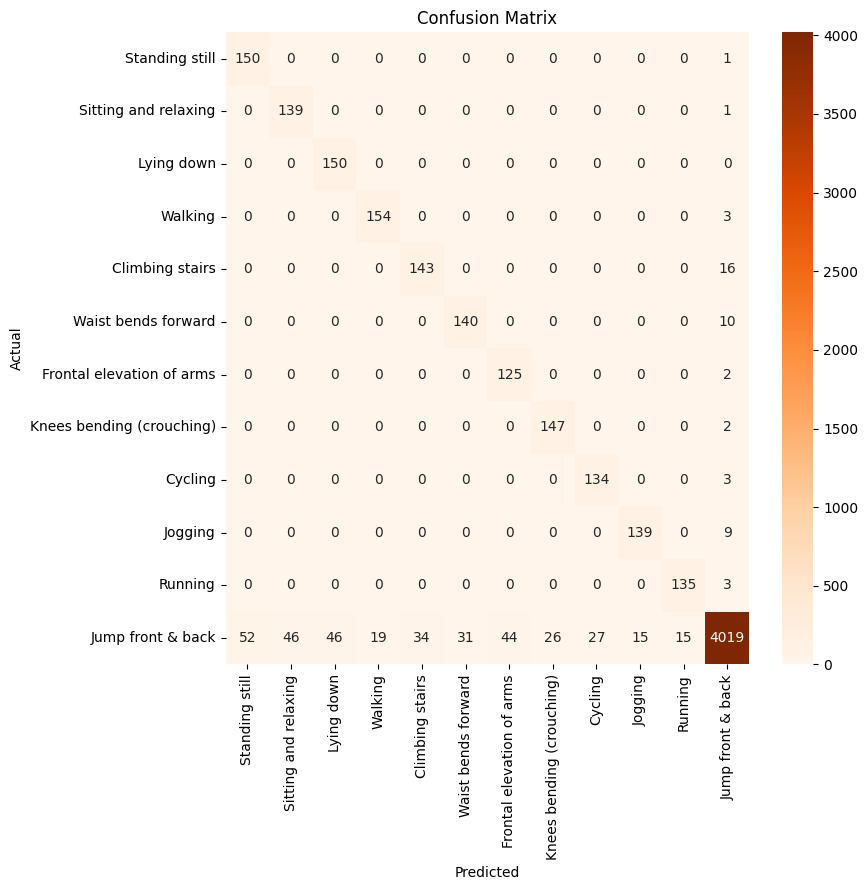

✅ Accuracy     : 93.23%
✅ Sensitivity  : 0.9654
✅ Specificity  : 0.9838
✅ MSE          : 3.7048
✅ Training Time: 1586.49 sec


In [9]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Classification Report:")
report = classification_report(y_true_labels, y_pred_labels, target_names=activity_labels.values(), output_dict=True)
print(classification_report(y_true_labels, y_pred_labels, target_names=activity_labels.values()))

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=activity_labels.values(),
            yticklabels=activity_labels.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

accuracy = np.mean(y_pred_labels == y_true_labels)
mse = mean_squared_error(y_true_labels, y_pred_labels)
sensitivity = np.mean([report[label]['recall'] for label in activity_labels.values()])

specificity_list = []
for i in range(len(activity_labels)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp_fn = cm.sum() - cm[:, i].sum()
    specificity_list.append(tn / fp_fn if fp_fn != 0 else 0)
specificity = np.mean(specificity_list)

print(f"✅ Accuracy     : {accuracy*100:.2f}%")
print(f"✅ Sensitivity  : {sensitivity:.4f}")
print(f"✅ Specificity  : {specificity:.4f}")
print(f"✅ MSE          : {mse:.4f}")
print(f"✅ Training Time: {end - start:.2f} sec")


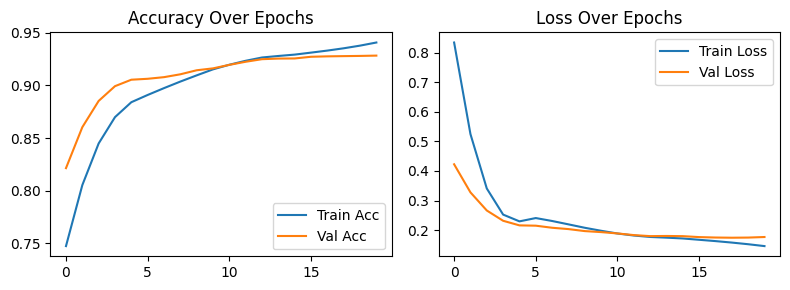

In [10]:
train_acc = savgol_filter(history.history['accuracy'], 9, 3)
val_acc = savgol_filter(history.history['val_accuracy'], 9, 3)
train_loss = savgol_filter(history.history['loss'], 9, 3)
val_loss = savgol_filter(history.history['val_loss'], 9, 3)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title("Loss Over Epochs")
plt.legend()
plt.tight_layout()
plt.show()


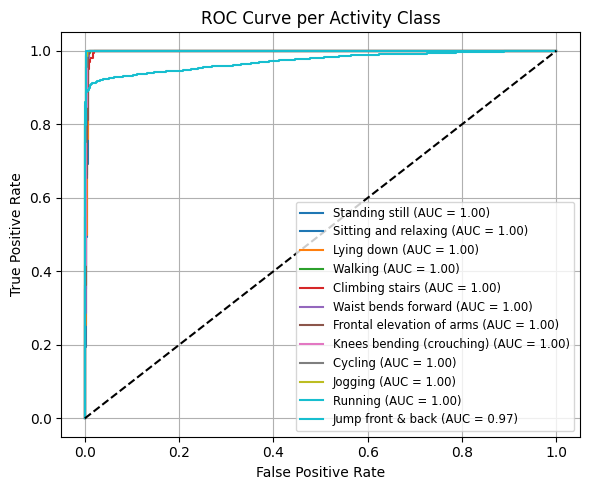

In [11]:
fpr = dict(); tpr = dict(); roc_auc = dict()
n_classes = y_test.shape[1]
colors = plt.cm.get_cmap('tab10', n_classes).colors

plt.figure(figsize=(6, 5))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i],
             label=f"{activity_labels[i+1]} (AUC = {roc_auc[i]:.2f})",
             color=colors[i % len(colors)])

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve per Activity Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"\n🎯 Train Accuracy: {train_acc*100:.2f}% | Loss: {train_loss:.4f}")
print(f"\n📊 Val Accuracy  : {val_acc*100:.2f}%   | Loss: {val_loss:.4f}")
print(f"\n✅ Test Accuracy : {test_acc*100:.2f}% | Loss: {test_loss:.4f}")



🎯 Train Accuracy: 94.72% | Loss: 0.1283

📊 Val Accuracy  : 92.64%   | Loss: 0.1801

✅ Test Accuracy : 93.23% | Loss: 0.1673
